Origin-destination matrices comparisons

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import computing_functions

C:\Users\hanic\AppData\Local\Temp\ipykernel_24160\904579155.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ksh_stats = pd.read_csv("data/sources/KSH/KSHSettlList_settlID_settlname_pop_lat_lon.csv")
ksh_flows_16 = pd.read_csv("data/sources/KSH/flows_16_cities.csv")
gravity_base = pd.read_csv("computing/odm/ODM_16_cities_gravity_unfitted.csv")
gravity_fitted = pd.read_csv("computing/odm/ODM_16_cities_gravity_fitted.csv")
entopy_max = (pd.read_csv("computing/odm/ODM_16_cities_entropy_max.csv")).rename(columns={"ODM_value": "flow"})
entopy_min = (pd.read_csv("computing/odm/ODM_16_cities_entropy_min.csv")).rename(columns={"ODM_value": "flow"})
bell_1 = pd.read_csv("computing/odm/ODM_16_cities_bell_from_entropy.csv")
bell_modified_1 = pd.read_csv("computing/odm/ODM_16_cities_bell_modified_from_entropy.csv")
bell_2 = pd.read_csv("computing/odm/ODM_16_cities_bell_from_gravity.csv")
bell_modified_2 = pd.read_csv("computing/odm/ODM_16_cities_bell_modified_from_gravity.csv")
cities = ['Budapest', 'Kecskemét', 'Szeged', 'Szolnok', 'Debrecen', 'Nyíregyháza', 'Miskolc', 'Dunaújváros', 'Szekszárd', 'Pécs', 'Székesfehérvár', 'Siófok', 'Győr', 'Sopron', 'Szombathely', 'Veszprém']

def replace_letters(s):
    return s.replace("õ", "ő").replace("Õ", "Ő").replace("û", "ű").replace("Û", "Ű")
#non_english_letters = r'[^a-zA-Z]'; non_hungarian_letters = r'[^a-zA-ZáéíóöőúüűÁÉÍÓÖŐÚÜŰ]'
#non_hungarian = ksh_stats['Settlement_Name'].str.contains(non_hungarian_str, regex=True)
ksh_stats['Settlement_Name'] = ksh_stats['Settlement_Name'].apply(replace_letters)

In [3]:
ksh_flows_16_nondiagonal = ksh_flows_16.copy()
for i, row in ksh_flows_16_nondiagonal.iterrows():
    if row['origin'] == row['destination']:
        ksh_flows_16_nondiagonal.loc[i, "flow"] = 0

In [4]:
def generate_id_dicts(ksh_flows_dir, origin_column_name='origName',origin_column_ID ='origID'):
    place_id_dict = {}
    for key, value in zip(ksh_flows_dir[origin_column_name], ksh_flows_dir[origin_column_ID]):
        if key in place_id_dict.keys():
            if place_id_dict[key] != value:
                print(key), print(value), print(place_id_dict[key])
        else:
            place_id_dict[key] = value
    place_id_dict['Budapest'] = 13578
    id_place_dict = { v:k for k, v in place_id_dict.items()}
    return place_id_dict, id_place_dict

place_id_dict, id_place_dict = generate_id_dicts(ksh_stats, 'Settlement_Name', 'Settlement_ID')

In [5]:
odm_2d = computing_functions.odm_ids_df_to_odm_2d_symmetric(ksh_flows_16,id_place_dict, cities)
odm_2d_nondiagonal = computing_functions.odm_ids_df_to_odm_2d_symmetric(ksh_flows_16_nondiagonal,id_place_dict, cities)

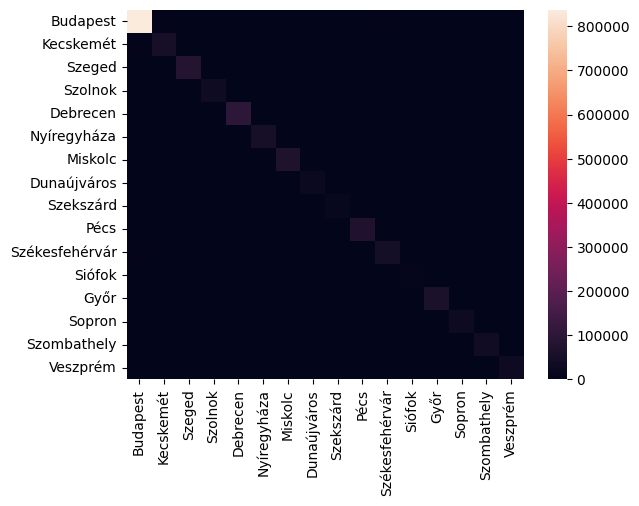

In [6]:
computing_functions.plot_odm(odm_2d, cities,)

Excluding the diagonal:

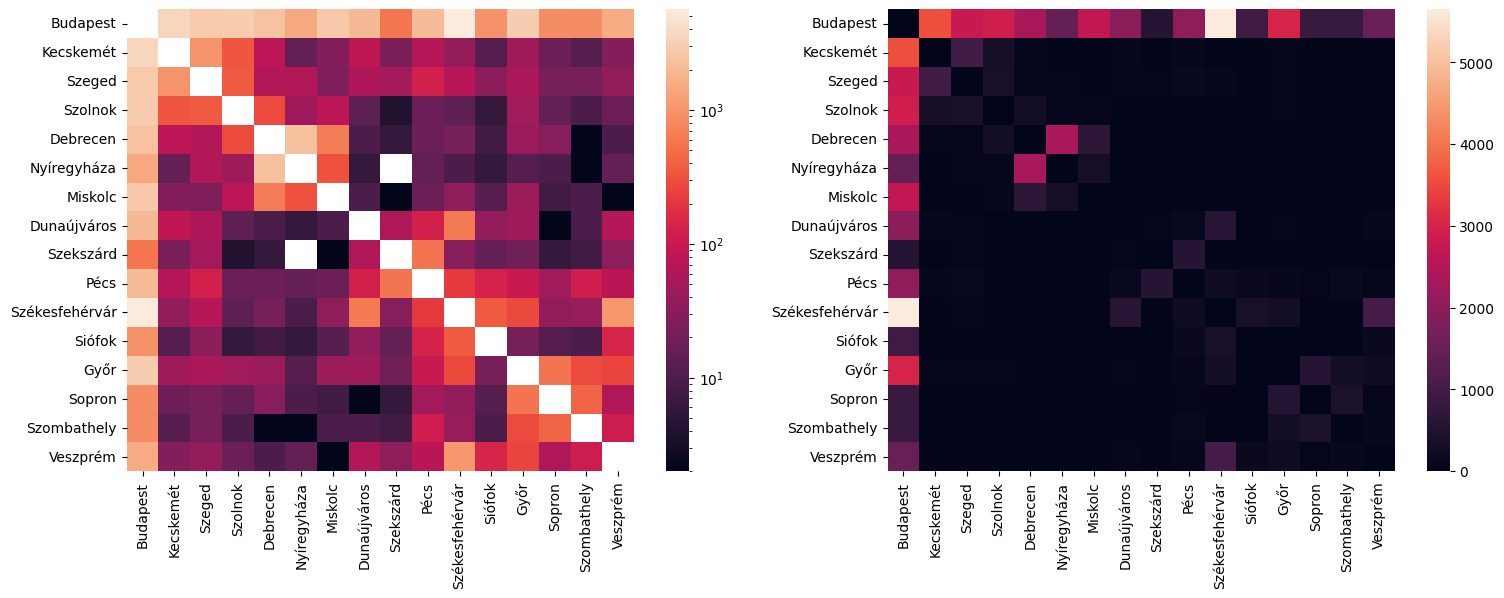

In [7]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
computing_functions.plot_odm_axis(odm_2d_nondiagonal, cities,log_scale=True, ax=ax[0])
computing_functions.plot_odm_axis(odm_2d_nondiagonal, cities,log_scale=False, ax=ax[1])

## Compare the computed ODMs 

In [8]:
odm_gravity_base = computing_functions.odm_location_names_df_to_odm_2d(gravity_base, cities)
odm_gravity_fitted = computing_functions.odm_location_names_df_to_odm_2d(gravity_fitted, cities)
odm_entropy_max = computing_functions.odm_location_names_df_to_odm_2d_symmetric(entopy_max, cities)
odm_entropy_min = computing_functions.odm_location_names_df_to_odm_2d_symmetric(entopy_min, cities)

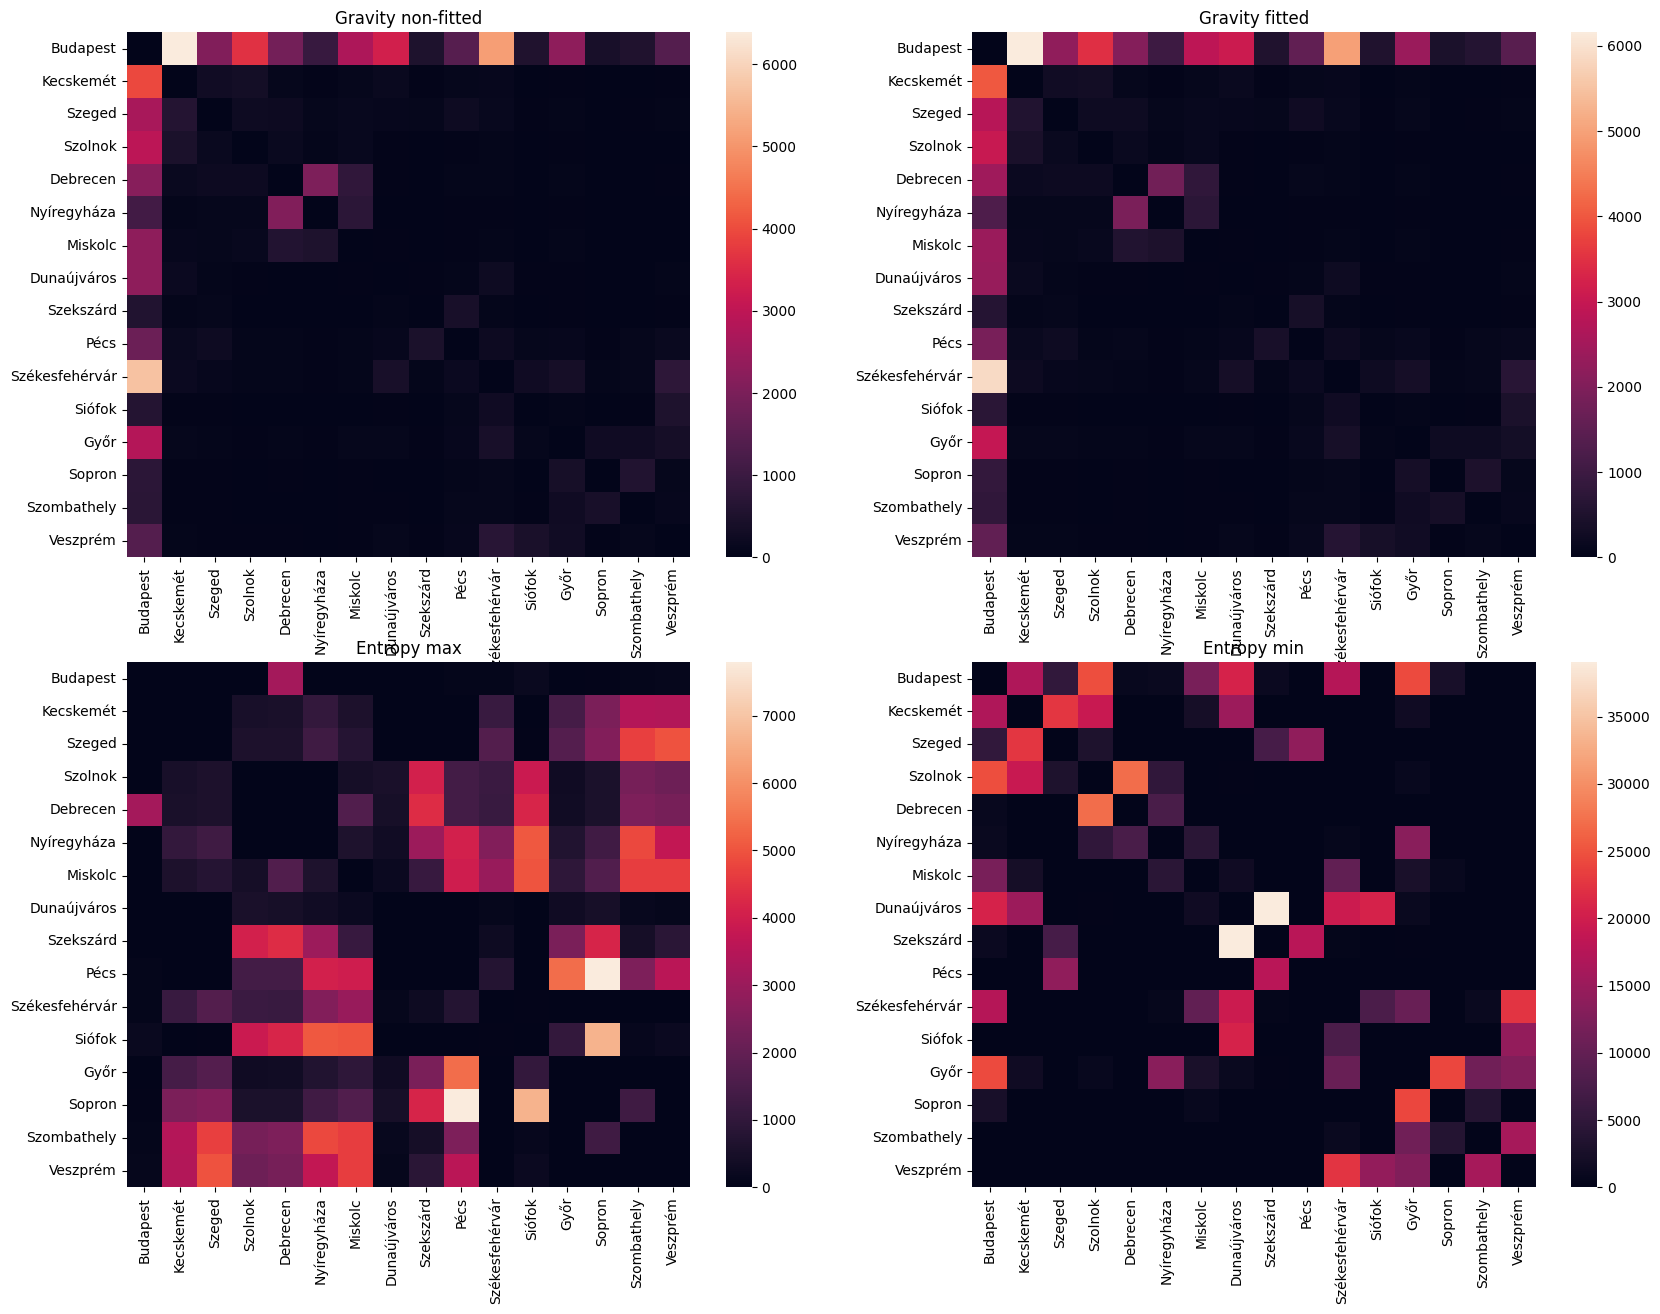

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
computing_functions.plot_odm_axis(odm_gravity_base, cities, ax=axs[0, 0])
computing_functions.plot_odm_axis(odm_gravity_fitted, cities, ax=axs[0, 1])
computing_functions.plot_odm_axis(odm_entropy_max, cities, ax=axs[1, 0])
computing_functions.plot_odm_axis(odm_entropy_min, cities, ax=axs[1, 1])

axs[0, 0].set_title('Gravity non-fitted')
axs[0, 1].set_title('Gravity fitted')
axs[1, 0].set_title('Entropy max')
axs[1, 1].set_title('Entropy min');


Difference plots:

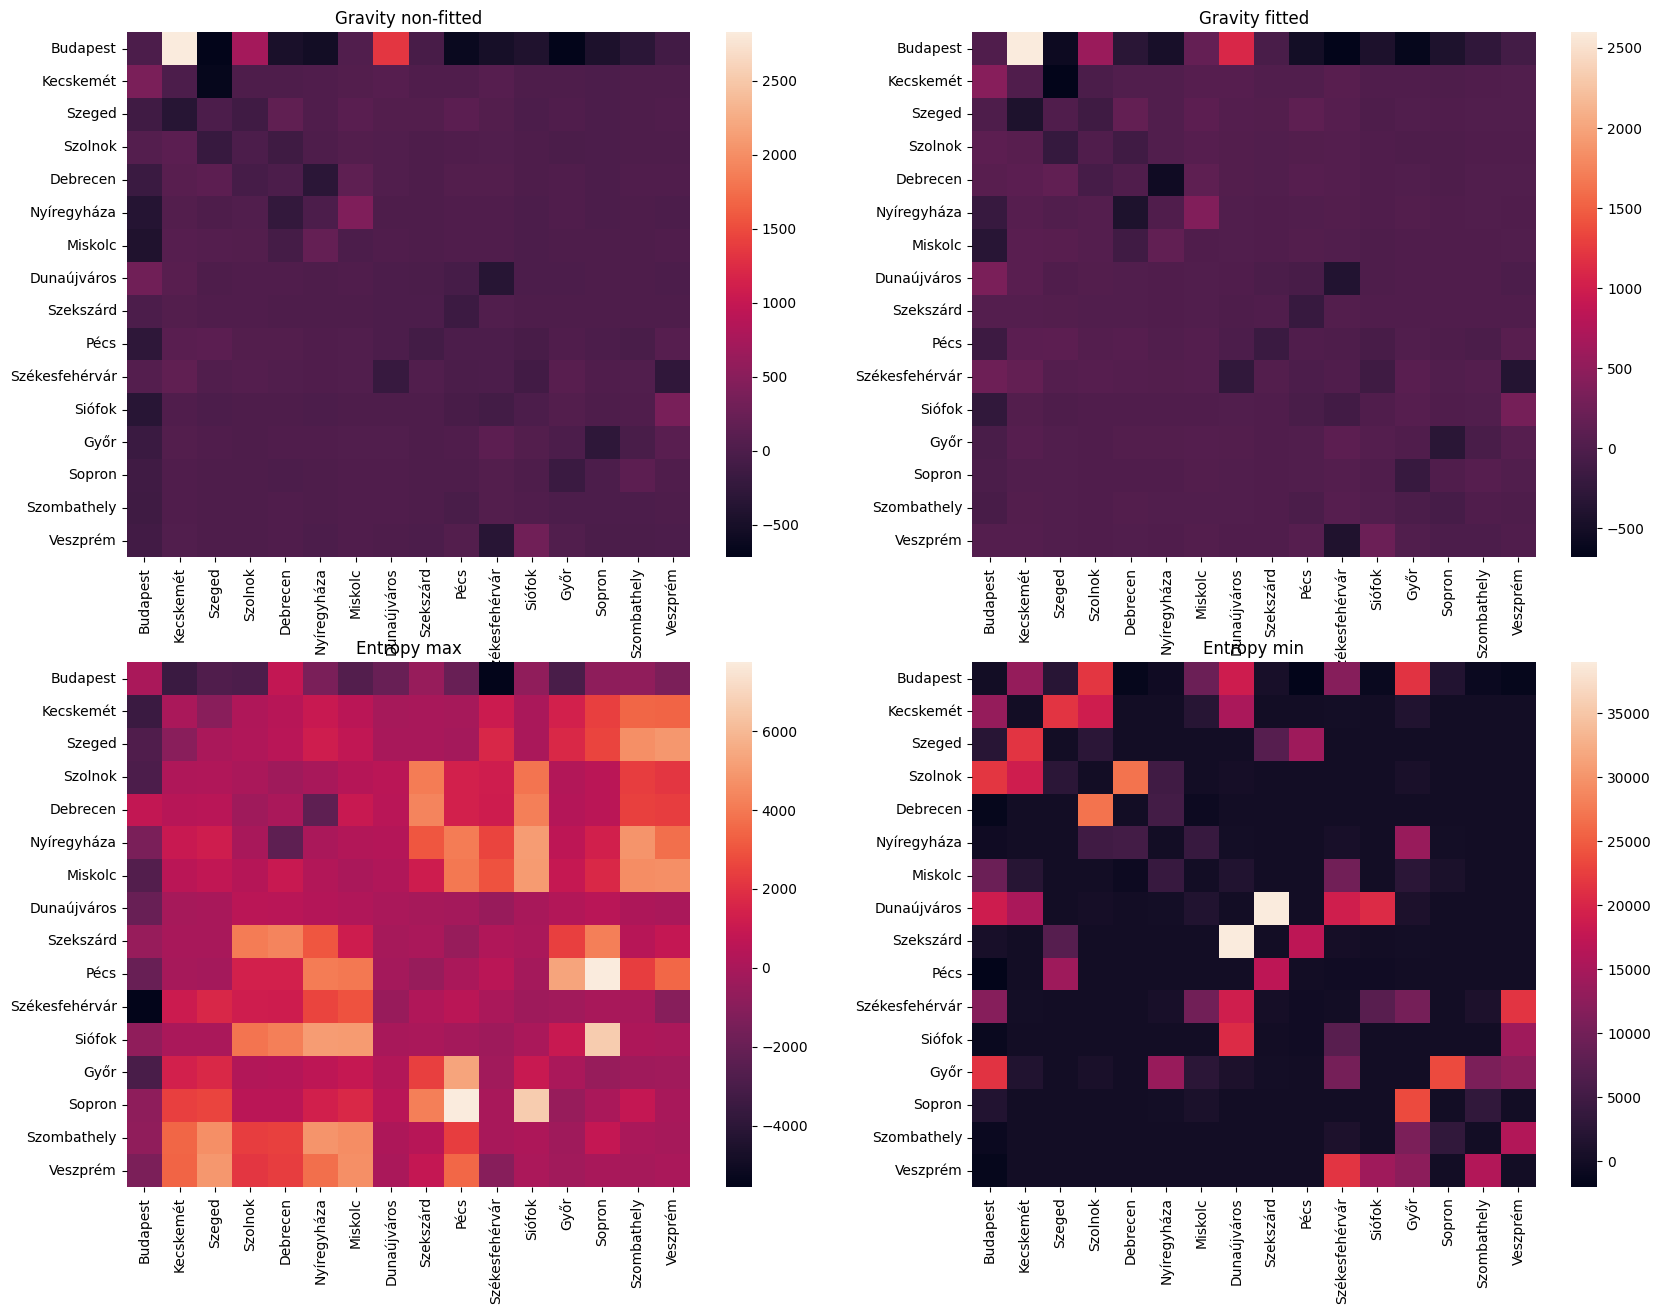

In [10]:
#Plot the 4 ODMs in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
computing_functions.plot_odm_axis(odm_gravity_base-odm_2d_nondiagonal, cities, ax=axs[0, 0])
computing_functions.plot_odm_axis(odm_gravity_fitted-odm_2d_nondiagonal, cities, ax=axs[0, 1])
computing_functions.plot_odm_axis(odm_entropy_max-odm_2d_nondiagonal, cities, ax=axs[1, 0])
computing_functions.plot_odm_axis(odm_entropy_min-odm_2d_nondiagonal, cities, ax=axs[1, 1])

#Set titles
axs[0, 0].set_title('Gravity non-fitted')
axs[0, 1].set_title('Gravity fitted')
axs[1, 0].set_title('Entropy max')
axs[1, 1].set_title('Entropy min');


Normalize to equal total flow: Set the models to have equal total flow as the original odm_2d_nondiagonal

In [11]:
def set_total_flow(odm, total_flow):
    return odm/np.sum(odm)*total_flow

total_flow = np.sum(odm_2d_nondiagonal)
odm_gravity_base_normalized = set_total_flow(odm_gravity_base, total_flow)
odm_gravity_fitted_normalized = set_total_flow(odm_gravity_fitted, total_flow)
odm_entropy_max_normalized = set_total_flow(odm_entropy_max, total_flow)
odm_entropy_min_normalized = set_total_flow(odm_entropy_min, total_flow)

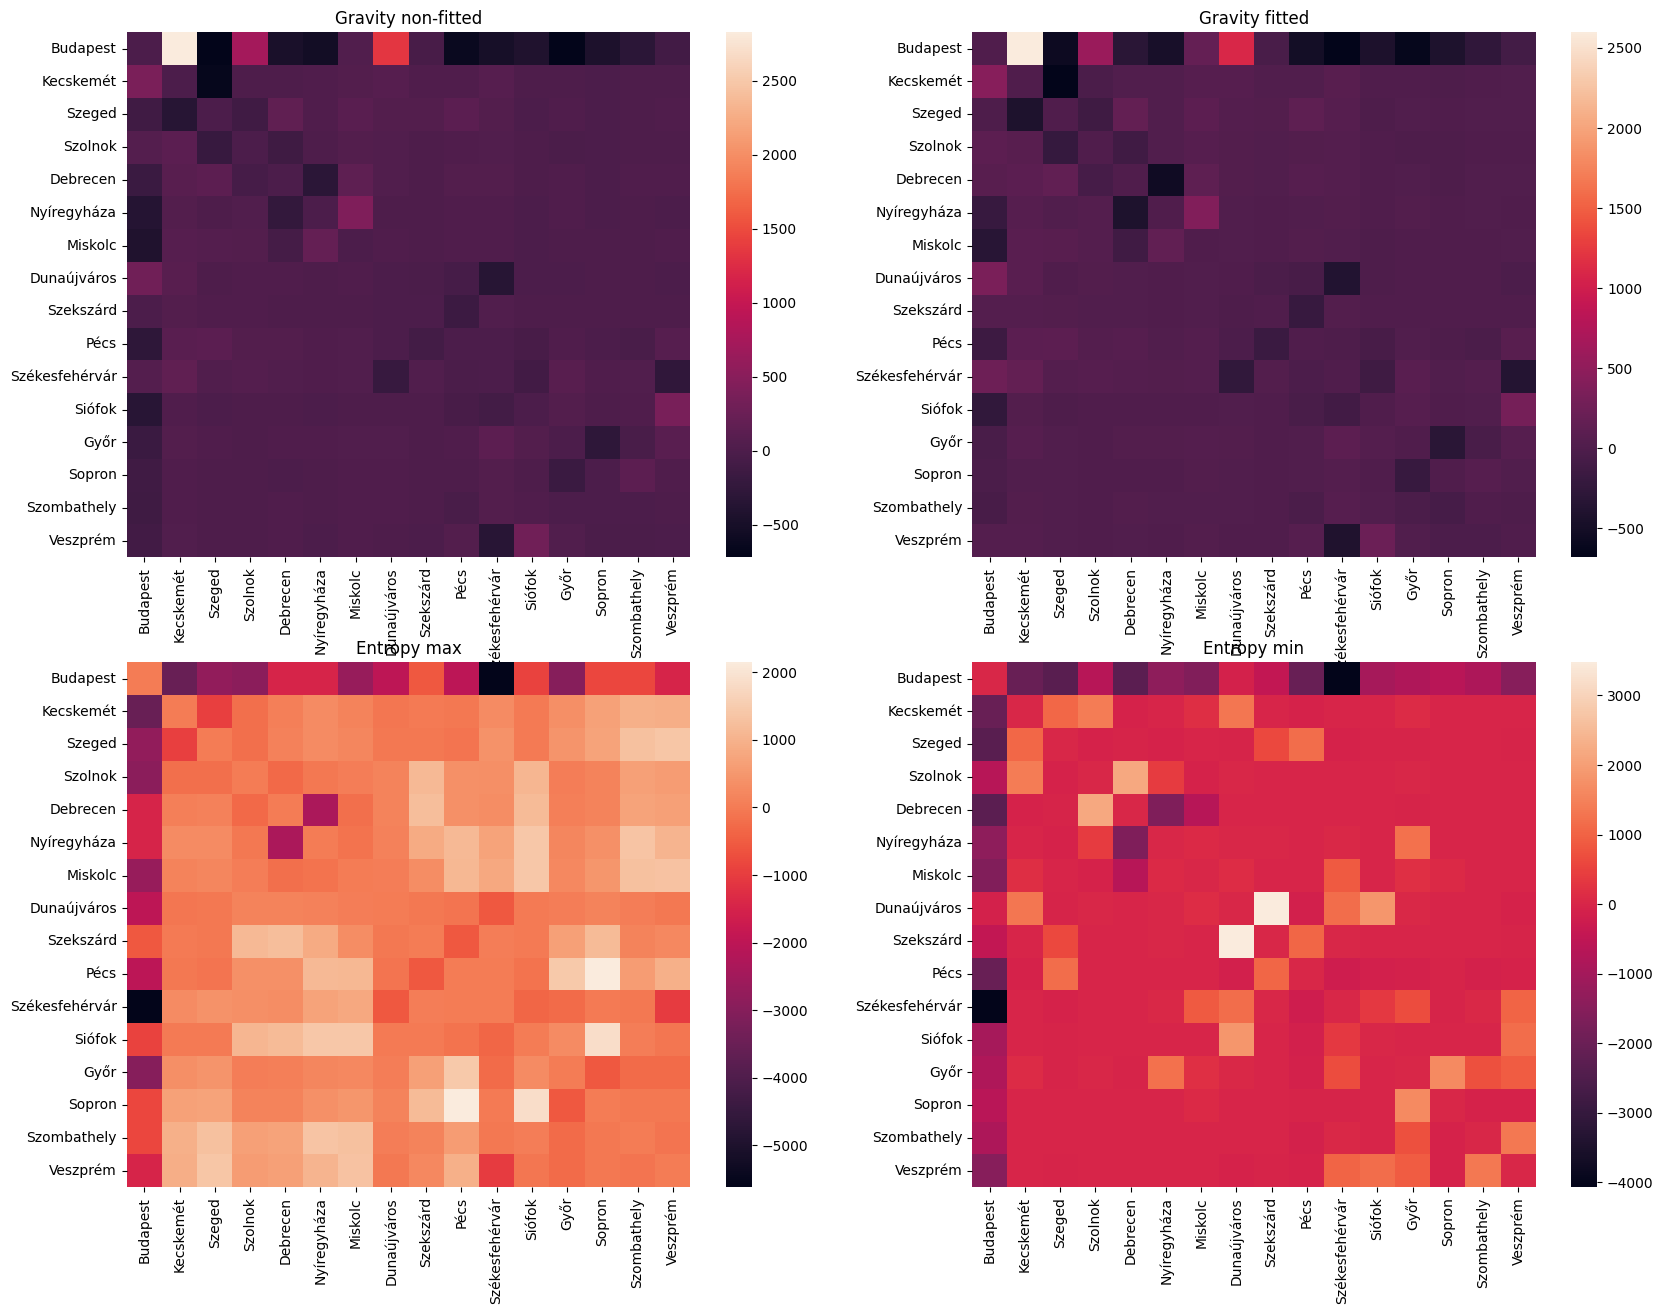

In [12]:
#Plot the 4 ODMs in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
computing_functions.plot_odm_axis(odm_gravity_base_normalized-odm_2d_nondiagonal, cities, ax=axs[0, 0])
computing_functions.plot_odm_axis(odm_gravity_fitted_normalized-odm_2d_nondiagonal, cities, ax=axs[0, 1])
computing_functions.plot_odm_axis(odm_entropy_max_normalized-odm_2d_nondiagonal, cities, ax=axs[1, 0])
computing_functions.plot_odm_axis(odm_entropy_min_normalized-odm_2d_nondiagonal, cities, ax=axs[1, 1])

#Set titles
axs[0, 0].set_title('Gravity non-fitted')
axs[0, 1].set_title('Gravity fitted')
axs[1, 0].set_title('Entropy max')
axs[1, 1].set_title('Entropy min');


We can see that the gravity model using the KSH data fits very well, surprisingly the power-law deterrence function works very well on large cities. On the other hand, the entropy minimizing model is very basic and does not use KSH data, and yet it still does fairly well.

In [13]:
mse_gravity, corr_gravity, sos_gravity = computing_functions.evaluate_model(odm_gravity_base_normalized, odm_2d_nondiagonal, "Gravity non-fitted", verbose=True)
mse_gravity_fitted, corr_gravity_fitted, sos_gravity_fitted = computing_functions.evaluate_model(odm_gravity_fitted_normalized, odm_2d_nondiagonal, "Gravity fitted", verbose=True)
mse_entropy_max, corr_entropy_max, sos_entropy_max = computing_functions.evaluate_model(odm_entropy_max_normalized, odm_2d_nondiagonal, "Entropy max", verbose=True)
mse_entropy_min, corr_entropy_min, sos_entropy_min = computing_functions.evaluate_model(odm_entropy_min_normalized, odm_2d_nondiagonal, "Entropy min", verbose=True)

MSE for Gravity non-fitted: 62479.68977725426
Correlation for Gravity non-fitted: 0.9583536081343225
SoS of relative differences for Gravity non-fitted: 1103.8494798581082

MSE for Gravity fitted: 53632.29434236803
Correlation for Gravity fitted: 0.9644175975912826
SoS of relative differences for Gravity fitted: 1278.0156241973934

MSE for Entropy max: 1141473.8721819748
Correlation for Entropy max: -0.23664880863708165
SoS of relative differences for Entropy max: 2837022.745919297

MSE for Entropy min: 698519.6928642213
Correlation for Entropy min: 0.42567385566303123
SoS of relative differences for Entropy min: 35906.41086891498



In [14]:
table = {
    'Model': ['Gravity non-fitted', 'Gravity fitted', 'Entropy max', 'Entropy min'],
    'MSE': [int(mse_gravity), int(mse_gravity_fitted), int(mse_entropy_max), int(mse_entropy_min)],
    'Correlation': [corr_gravity, corr_gravity_fitted, corr_entropy_max, corr_entropy_min],
    'SoS of relative differences': [int(sos_gravity), int(sos_gravity_fitted), int(sos_entropy_max), int(sos_entropy_min)],
    'Note': ['Geographical closeness bias', 'Not much difference to non-fitted', 'Bias on far distances', 'Bias on directly connected cities']
}

df1 = pd.DataFrame(table)
df1

,Model,MSE,Correlation,SoS of relative differences,Note
0,Gravity non-fitted,62479,0.958354,1103,Geographical closeness bias
1,Gravity fitted,53632,0.964418,1278,Not much difference to non-fitted
2,Entropy max,1141473,-0.236649,2837022,Bias on far distances
3,Entropy min,698519,0.425674,35906,Bias on directly connected cities


Note: Entropy_min_previous had 55% correlation, and only ~12000 SoS error

In [15]:
qr1 = np.divide(odm_gravity_base_normalized, odm_2d_nondiagonal, where=odm_2d_nondiagonal!=0)
qr2 = np.divide(odm_gravity_fitted_normalized, odm_2d_nondiagonal, where=odm_2d_nondiagonal!=0)
qr1[5,8] = 0; qr1[8,5] = 0; qr2[5,8] = 0; qr2[8,5] = 0
np.fill_diagonal(qr1, 0); np.fill_diagonal(qr2, 0)

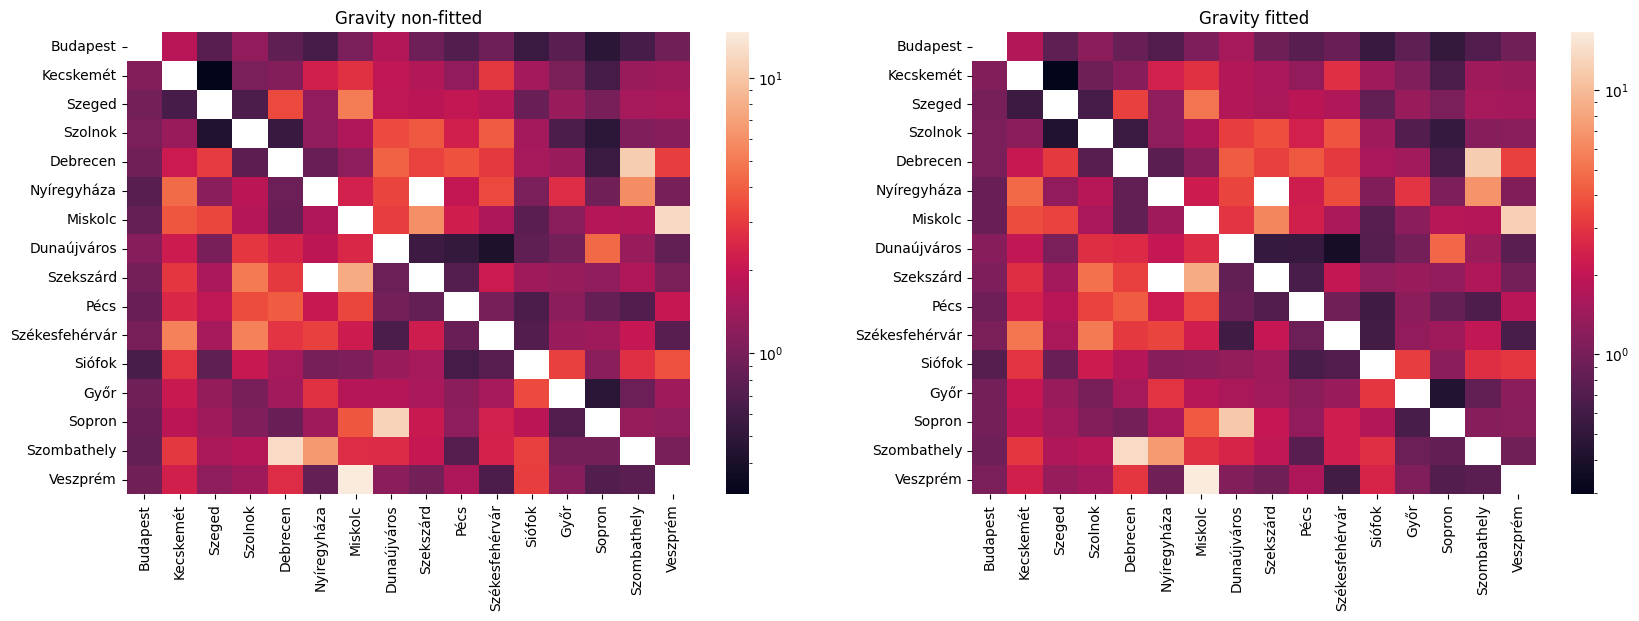

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
computing_functions.plot_odm_axis(qr1, cities, ax=axs[0], log_scale=True, title="Gravity non-fitted")
computing_functions.plot_odm_axis(qr2, cities, ax=axs[1], log_scale=True, title="Gravity fitted")

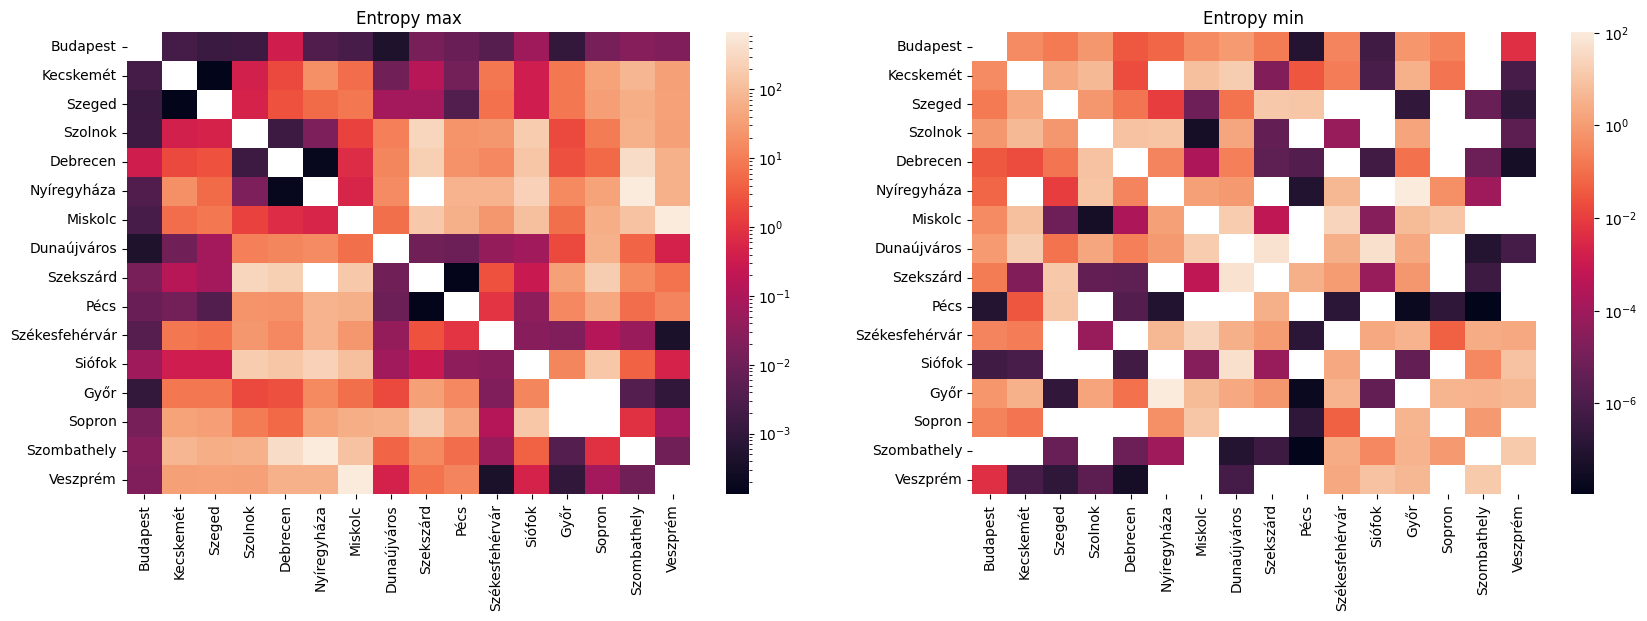

In [17]:
qr3 = np.divide(odm_entropy_max_normalized, odm_2d_nondiagonal, where=odm_2d_nondiagonal!=0)
qr4 = np.divide(odm_entropy_min_normalized, odm_2d_nondiagonal, where=odm_2d_nondiagonal!=0)
qr3[5,8] = 0; qr3[8,5] = 0; qr4[5,8] = 0; qr4[8,5] = 0
np.fill_diagonal(qr3, 0); np.fill_diagonal(qr4, 0)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
computing_functions.plot_odm_axis(qr3, cities, ax=axs[0], log_scale=True, title="Entropy max")
computing_functions.plot_odm_axis(qr4, cities, ax=axs[1], log_scale=True, title="Entropy min")

## Bell models

In [18]:
odm_bell_1 = computing_functions.odm_location_names_df_to_odm_2d_symmetric(bell_1, cities)
odm_bell_modified_1 = computing_functions.odm_location_names_df_to_odm_2d_symmetric(bell_modified_1, cities)
odm_bell_2 = computing_functions.odm_location_names_df_to_odm_2d_symmetric(bell_2, cities)
odm_bell_modified_2 = computing_functions.odm_location_names_df_to_odm_2d_symmetric(bell_modified_2, cities)

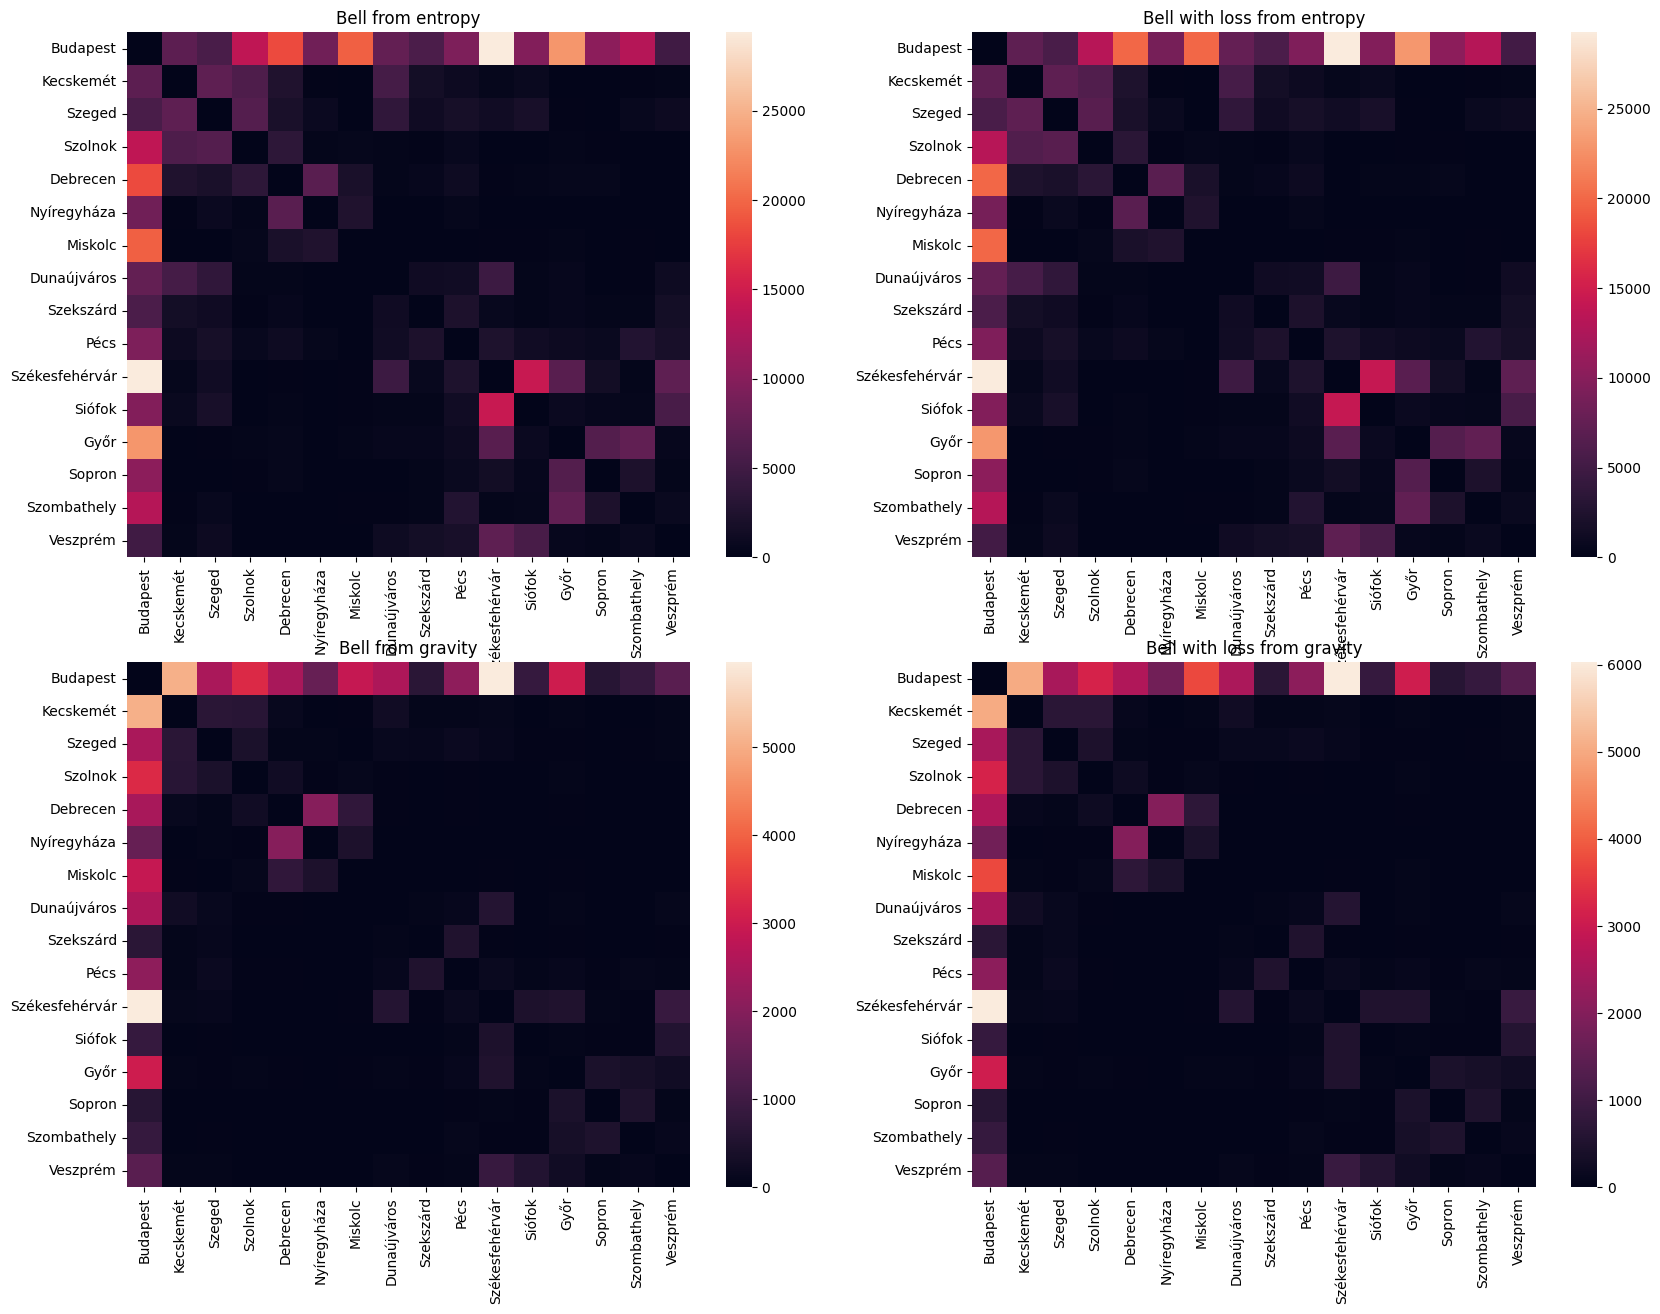

In [19]:
#Plot the 4 ODMs in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
computing_functions.plot_odm_axis(odm_bell_1, cities, ax=axs[0, 0])
computing_functions.plot_odm_axis(odm_bell_modified_1, cities, ax=axs[0, 1])
computing_functions.plot_odm_axis(odm_bell_2, cities, ax=axs[1, 0])
computing_functions.plot_odm_axis(odm_bell_modified_2, cities, ax=axs[1, 1])

#Set titles
axs[0, 0].set_title('Bell from entropy')
axs[0, 1].set_title('Bell with loss from entropy')
axs[1, 0].set_title('Bell from gravity')
axs[1, 1].set_title('Bell with loss from gravity');

Normalize and see difference plots:

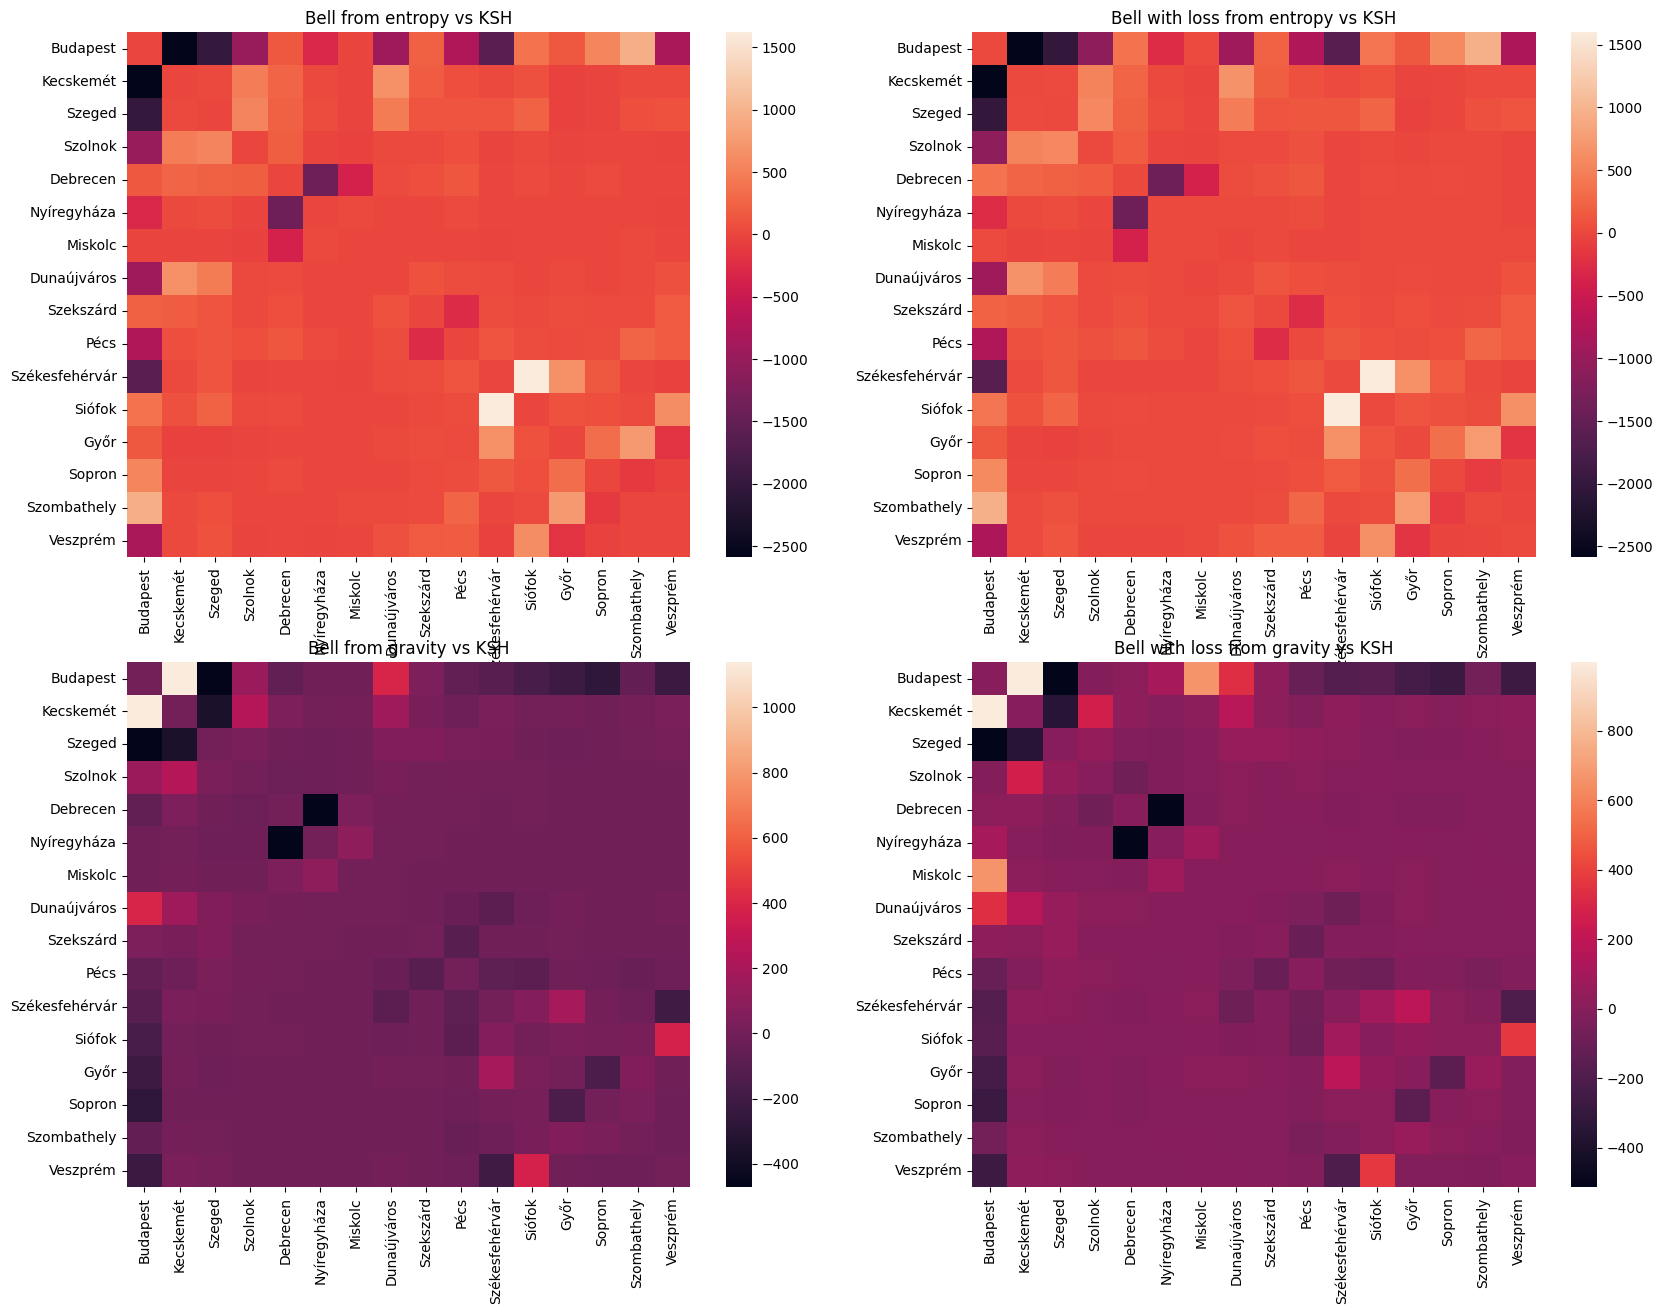

In [20]:
odm_bell_1_normalized = set_total_flow(odm_bell_1, total_flow)
odm_bell_modified_1_normalized = set_total_flow(odm_bell_modified_1, total_flow)
odm_bell_2_normalized = set_total_flow(odm_bell_2, total_flow)
odm_bell_modified_2_normalized = set_total_flow(odm_bell_modified_2, total_flow)

#Plot the 4 ODMs in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
computing_functions.plot_odm_axis(odm_bell_1_normalized-odm_2d_nondiagonal, cities, ax=axs[0, 0])
computing_functions.plot_odm_axis(odm_bell_modified_1_normalized-odm_2d_nondiagonal, cities, ax=axs[0, 1])
computing_functions.plot_odm_axis(odm_bell_2_normalized-odm_2d_nondiagonal, cities, ax=axs[1, 0])
computing_functions.plot_odm_axis(odm_bell_modified_2_normalized-odm_2d_nondiagonal, cities, ax=axs[1, 1])

#Set titles
axs[0, 0].set_title('Bell from entropy vs KSH')
axs[0, 1].set_title('Bell with loss from entropy vs KSH')
axs[1, 0].set_title('Bell from gravity vs KSH')
axs[1, 1].set_title('Bell with loss from gravity vs KSH');

Errors:

In [21]:
mse_bell_1, corr_bell_1, sos_bell_1 = computing_functions.evaluate_model(odm_bell_1_normalized, odm_2d_nondiagonal, "Bell from entropy", verbose=True)
mse_bell_modified_1, corr_bell_modified_1, sos_bell_modified_1 = computing_functions.evaluate_model(odm_bell_modified_1_normalized, odm_2d_nondiagonal, "Bell with loss from entropy", verbose=True)
mse_bell_2, corr_bell_2, sos_bell_2 = computing_functions.evaluate_model(odm_bell_2_normalized, odm_2d_nondiagonal, "Bell from gravity", verbose=True)
mse_bell_modified_2, corr_bell_modified_2, sos_bell_modified_2 = computing_functions.evaluate_model(odm_bell_modified_2_normalized, odm_2d_nondiagonal, "Bell with loss from gravity", verbose=True)

table = {
    'Model': ['Bell from entropy', 'Bell with loss from entropy', 'Bell from gravity', 'Bell with loss from gravity'],
    'MSE': [int(mse_bell_1), int(mse_bell_modified_1), int(mse_bell_2), int(mse_bell_modified_2)],
    'Correlation': [corr_bell_1, corr_bell_modified_1, corr_bell_2, corr_bell_modified_2],
    'SoS of relative differences': [int(sos_bell_1), int(sos_bell_modified_1), int(sos_bell_2), int(sos_bell_modified_2)],
    'Note': ['', 'With loss', '', 'With loss']
}

df2 = pd.DataFrame(table)
pd.concat([df1, df2])

MSE for Bell from entropy: 203452.62047687103
Correlation for Bell from entropy: 0.8487747020453531
SoS of relative differences for Bell from entropy: 1743.5308337550614

MSE for Bell with loss from entropy: 205789.5066079141
Correlation for Bell with loss from entropy: 0.8463978274392634
SoS of relative differences for Bell with loss from entropy: 1686.213013061012

MSE for Bell from gravity: 20686.41916171963
Correlation for Bell from gravity: 0.985890529334097
SoS of relative differences for Bell from gravity: 75.38432434948352

MSE for Bell with loss from gravity: 22722.186481171448
Correlation for Bell with loss from gravity: 0.9845585643504262
SoS of relative differences for Bell with loss from gravity: 71.23522112833612



,Model,MSE,Correlation,SoS of relative differences,Note
0,Gravity non-fitted,62479,0.958354,1103,Geographical closeness bias
1,Gravity fitted,53632,0.964418,1278,Not much difference to non-fitted
2,Entropy max,1141473,-0.236649,2837022,Bias on far distances
3,Entropy min,698519,0.425674,35906,Bias on directly connected cities
0,Bell from entropy,203452,0.848775,1743,
1,Bell with loss from entropy,205789,0.846398,1686,With loss
2,Bell from gravity,20686,0.985891,75,
3,Bell with loss from gravity,22722,0.984559,71,With loss
